In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
!wget -q http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

In [9]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id',
                                                         'rating','timestamp'])

In [6]:
ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [10]:
movies = pd.read_csv(
    'ml-100k/u.item',
    sep='|',
    encoding='latin-1',
    names=['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] +
          [f'genre_{i}' for i in range(19)],
    usecols=[0, 1]
)

In [8]:
movies

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [9]:
print(ratings.shape)

(100000, 4)


In [15]:
movies['item_id'].nunique()

1682

In [10]:
print(ratings.user_id.nunique())

943


In [12]:
#sparsity
1-(len(ratings))/(ratings.user_id.nunique()*ratings.item_id.nunique())

0.9369533063577546

In [13]:
#94% sparse

In [14]:
#ratings per user
ratings.user_id.value_counts()

,count
user_id,
405,737
655,685
13,636
450,540
276,518
...,...
36,20
418,20
558,20


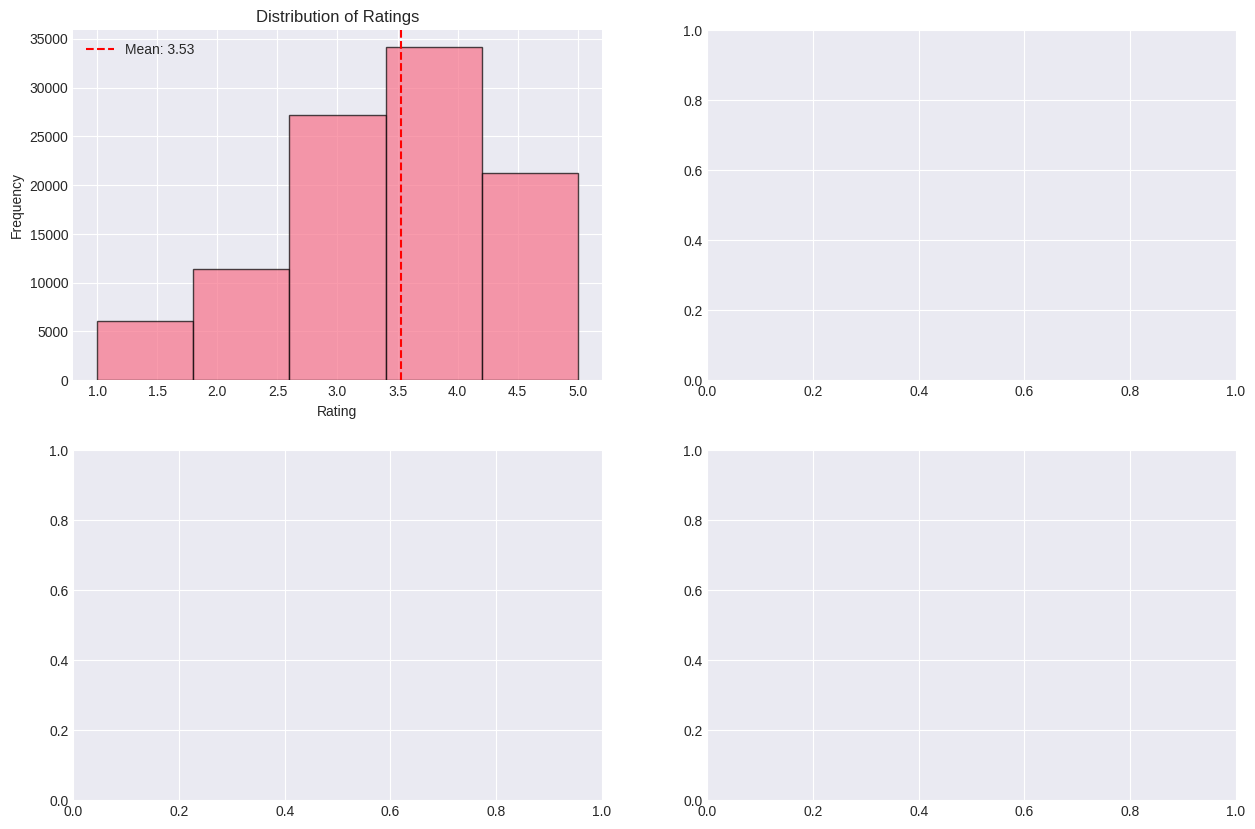

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
axes[0, 0].hist(ratings['rating'], bins=5, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Ratings')
axes[0, 0].axvline(ratings['rating'].mean(), color='red', linestyle='--', label=f'Mean: {ratings["rating"].mean():.2f}')
axes[0, 0].legend()

In [17]:
user_rating_counts = ratings.groupby('user_id').size()
axes[0, 1].hist(user_rating_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Ratings')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_title('Ratings per User Distribution')
axes[0, 1].axvline(user_rating_counts.mean(), color='red', linestyle='--', label=f'Mean: {user_rating_counts.mean():.0f}')
axes[0, 1].legend()

In [18]:
movie_rating_counts = ratings.groupby('item_id').size()
axes[1, 0].hist(movie_rating_counts, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Ratings')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].set_title('Ratings per Movie Distribution')
axes[1, 0].axvline(movie_rating_counts.mean(), color='red', linestyle='--', label=f'Mean: {movie_rating_counts.mean():.0f}')
axes[1, 0].legend()


In [19]:
# Average rating per user
user_avg_ratings = ratings.groupby('user_id')['rating'].mean()
axes[1, 1].hist(user_avg_ratings, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Number of Users')
axes[1, 1].set_title('Average Rating per User')
axes[1, 1].axvline(user_avg_ratings.mean(), color='red', linestyle='--', label=f'Mean: {user_avg_ratings.mean():.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [20]:
print("\n📊 Key Observations:")
print(f"1. Users have rated {user_rating_counts.mean():.0f} movies on average")
print(f"2. Movies have been rated {movie_rating_counts.mean():.0f} times on average")
print(f"3. Most common rating: {ratings['rating'].mode()[0]}")
print(f"4. Standard deviation of ratings: {ratings['rating'].std():.2f}")


📊 Key Observations:
1. Users have rated 106 movies on average
2. Movies have been rated 59 times on average
3. Most common rating: 4
4. Standard deviation of ratings: 1.13


In [11]:
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

In [23]:
print(len(train_data))

80000


In [24]:
print(len(test_data))

20000


In [12]:
user_ids = ratings['user_id'].unique()
item_ids = ratings['item_id'].unique()

In [13]:
n_users = len(user_ids)
n_items = len(item_ids)

In [30]:
train_data

,user_id,item_id,rating,timestamp
75220,807,1411,1,893082619
48955,474,659,5,887925187
44966,463,268,4,877384940
13568,139,286,4,879537844
92727,621,751,4,883799651
...,...,...,...,...
6265,216,231,2,880245109
54886,343,276,5,876403078
76820,437,475,3,880140288
860,284,322,3,885329671


In [27]:
#matrix factorisation, basic implementation

In [33]:
class BasicMatrixFactorization:
  def __init__(self, n_users, n_items, n_factors=20, reg_lambda=0.02,
               learning_rate=0.01, random_state=123
               ):
    self.n_users = n_users
    self.n_items = n_items
    self.n_factors = n_factors
    self.reg_lambda = reg_lambda
    self.learning_rate = learning_rate
    self.random_state = random_state

    np.random.seed(self.random_state)

    self.P = np.random.normal(0, 0.1, size = (n_users, n_factors))
    self.Q = np.random.normal(0, 0.1, size = (n_items, n_factors))

    self.train_losses = []

  def predict(self, user_id, item_id):
    return np.dot(self.P[user_id], self.Q[item_id])

  def fit(self, train_data, n_epochs=10):
    for epoch in range(n_epochs):

      shuffled_data = train_data.sample(frac=1).reset_index(drop=True)
      epoch_loss = 0

      for _, row in shuffled_data.iterrows():
        u = row['user_id'] - 1
        i = row['item_id'] - 1
        r_ui = row['rating']

        error = r_ui - self.predict(u, i)
        epoch_loss += error**2

        p_u_old = self.P[u].copy()

        self.P[u] += self.learning_rate * (error * self.Q[i] - self.reg_lambda * self.P[u])
        self.Q[i] += self.learning_rate * (error * p_u_old - self.reg_lambda * self.Q[i])

      avg_loss = epoch_loss / len(shuffled_data)
      self.train_losses.append(avg_loss)
      print(f"Epoch {epoch + 1}/{n_epochs} - Loss: {avg_loss}")

  def evaluate(self, test_data):
    predictions = []
    actuals = []
    for _, row in test_data.iterrows():
      u = row['user_id'] - 1
      i = row['item_id'] - 1
      r_ui = row['rating']
      predictions.append(self.predict(u, i))
      actuals.append(r_ui)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
    return rmse, mae, predictions, actuals









In [34]:
obj = BasicMatrixFactorization(n_users, n_items, n_factors=20, reg_lambda=0.02, learning_rate=0.01, random_state=123)

In [35]:
obj.fit(train_data, n_epochs=20)

Epoch 1/20 - Loss: 12.512633467634842
Epoch 2/20 - Loss: 2.9366888790387735
Epoch 3/20 - Loss: 1.2681264361056095
Epoch 4/20 - Loss: 1.0217308401994865
Epoch 5/20 - Loss: 0.933635009436303
Epoch 6/20 - Loss: 0.8855171925623294
Epoch 7/20 - Loss: 0.8478019382333168
Epoch 8/20 - Loss: 0.8136659968984671
Epoch 9/20 - Loss: 0.7825087739550084
Epoch 10/20 - Loss: 0.751647650820873
Epoch 11/20 - Loss: 0.7225728978394099
Epoch 12/20 - Loss: 0.6953227875199934
Epoch 13/20 - Loss: 0.6688186358087292
Epoch 14/20 - Loss: 0.6445892357072889
Epoch 15/20 - Loss: 0.6207976692582129
Epoch 16/20 - Loss: 0.5994674702650744
Epoch 17/20 - Loss: 0.5797125758069235
Epoch 18/20 - Loss: 0.5615121022038781
Epoch 19/20 - Loss: 0.5444770781059798
Epoch 20/20 - Loss: 0.5293241486832762


In [36]:
rmse, mae, preds, actuals = obj.evaluate(test_data)

In [37]:
rmse

np.float64(0.9509204397757297)

In [38]:
mae

np.float64(0.7428709597905672)


📊 Basic Model Performance:
RMSE: 0.9509
MAE: 0.7429


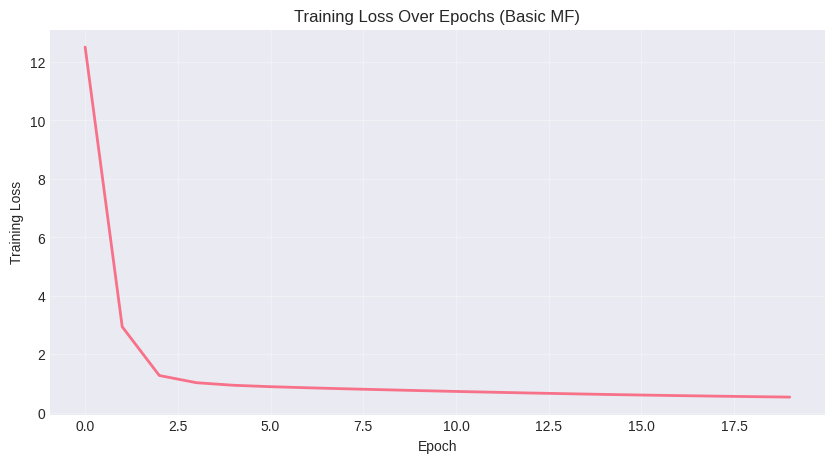

In [39]:
print(f"\n📊 Basic Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(obj.train_losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs (Basic MF)')
plt.grid(True, alpha=0.3)
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [43]:
class RatingsDataset(Dataset):
  def __init__(self, ratings_df):
    self.users = torch.LongTensor(ratings_df['user_id'].values - 1)
    self.items = torch.LongTensor(ratings_df['item_id'].values - 1)
    self.ratings = torch.FloatTensor(ratings_df['rating'].values)

  def __len__(self):
    return len(self.ratings)

  def __getitem__(self, idx):
    return self.users[idx], self.items[idx], self.ratings[idx]

In [44]:
train_dataset = RatingsDataset(train_data)

In [45]:
train_dataset

In [46]:
test_dataset = RatingsDataset(test_data)

In [47]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)


In [48]:
len(train_loader)

313

In [49]:
len(test_loader)

79

In [50]:
class NeuralCollaborativeFiltering(nn.Module):
  def __init__(self, n_users, n_items, embedding_dim=32, hidden_layers=[64, 32, 16], dropout=0.2):
    super(NeuralCollaborativeFiltering, self).__init__()
    self.n_users = n_users
    self.n_items = n_items
    self.embedding_dim = embedding_dim

    #GMF embeddings for GMF path
    self.user_embeddings_gmf = nn.Embedding(n_users, embedding_dim)
    self.item_embeddings_gmf = nn.Embedding(n_items, embedding_dim)

    #MLP embeddings for MLP path
    self.user_embeddings_mlp = nn.Embedding(n_users, embedding_dim)
    self.item_embeddings_mlp = nn.Embedding(n_items, embedding_dim)

    #MLP Layers
    mlp_layers = []
    input_size = 2*embedding_dim
    for hidden_layer in hidden_layers:
      mlp_layers.append(nn.Linear(input_size, hidden_layer))
      mlp_layers.append(nn.ReLU())
      mlp_layers.append(nn.BatchNorm1d(hidden_layer))
      mlp_layers.append(nn.Dropout(dropout))
      input_size = hidden_layer
    self.mlp = nn.Sequential(*mlp_layers)
    self.final_layer = nn.Linear(self.embedding_dim+hidden_layers[-1], 1)

    #biases
    self.user_bias = nn.Embedding(n_users, 1)
    self.item_bias = nn.Embedding(n_items, 1)
    self.global_bias = nn.Parameter(torch.zeros(1))

    #initialize_weights
    self._init_weights()

  def _init_weights(self):
    nn.init.xavier_uniform_(self.user_embeddings_gmf.weight)
    nn.init.xavier_uniform_(self.item_embeddings_gmf.weight)
    nn.init.xavier_uniform_(self.user_embeddings_mlp.weight)
    nn.init.xavier_uniform_(self.item_embeddings_mlp.weight)
    nn.init.zeros_(self.user_bias.weight)
    nn.init.zeros_(self.item_bias.weight)

  def forward(self, user_ids, item_ids):
    user_emb_gmf = self.user_embeddings_gmf(user_ids)
    item_emb_gmf = self.item_embeddings_gmf(item_ids)
    gmf_output = user_emb_gmf * item_emb_gmf

    user_emb_mlp = self.user_embeddings_mlp(user_ids)
    item_emb_mlp = self.item_embeddings_mlp(item_ids)

    mlp_input = torch.cat([user_emb_mlp, item_emb_mlp], dim=-1)
    mlp_output = self.mlp(mlp_input)

    combined = torch.cat([gmf_output, mlp_output], dim=-1)
    prediction = self.final_layer(combined)

    prediction = prediction.squeeze() + self.user_bias(user_ids).squeeze() + self.item_bias(item_ids).squeeze() + self.global_bias

    return prediction

  def get_embeddings(self):
    return {
        'user_gmf':self.user_embeddings_gmf.weight.detach().cpu().numpy(),
        'item_gmf':self.item_embeddings_gmf.weight.detach().cpu().numpy(),
        'user_mlp':self.user_embeddings_mlp.weight.detach().cpu().numpy(),
        'item_mlp':self.item_embeddings_mlp.weight.detach().cpu().numpy(),
        'user_bias':self.user_bias.weight.detach().cpu().numpy(),
        'item_bias':self.item_bias.weight.detach().cpu().numpy(),
        'global_bias':self.global_bias.detach().cpu().numpy()
    }

In [57]:
#train the model
def train_ncf_model(model, train_loader, test_loader, n_epochs=10, lr=0.001):
  model = model.to(device)
  criterion = nn.MSELoss()
  optimiser = optim.Adam(model.parameters(), lr=lr)

  #Learning rate scheduler
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=3)

  train_losses = []
  test_losses = []
  test_rmses = []
  best_rmse = float('inf')

  for epoch in range(n_epochs):
    model.train()
    train_epoch_loss = 0

    for user_ids, item_ids, ratings in train_loader:
      user_ids = user_ids.to(device)
      item_ids = item_ids.to(device)
      ratings = ratings.to(device)

      predictions = model(user_ids, item_ids)
      loss = criterion(predictions, ratings)

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      train_epoch_loss += loss.item()*len(ratings)
      train_epoch_loss = train_epoch_loss/len(train_loader.dataset)
      train_losses.append(train_epoch_loss)

  #eval
  model.eval()
  epoch_test_loss = 0
  all_predictions = []
  all_actuals = []

  with torch.no_grad():
    for user_ids, item_ids, ratings in test_loader:
      user_ids = user_ids.to(device)
      item_ids = item_ids.to(device)
      ratings = ratings.to(device)

      predictions = model(user_ids, item_ids)
      loss = criterion(predictions, ratings)

      epoch_test_loss+= loss.item()*len(ratings)
      all_predictions.extend(predictions.cpu().numpy())
      all_actuals.extend(ratings.cpu().numpy())

    epoch_test_loss = epoch_test_loss/len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    test_rmses.append(rmse)

    scheduler.step(rmse)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_epoch = epoch + 1

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}")
        print(f"  Train Loss: {train_epoch_loss:.4f}")
        print(f"  Test Loss: {epoch_test_loss:.4f}")
        print(f"  Test RMSE: {rmse:.4f}")
        print()

    print(f"\nTraining completed!")
    print(f"Best RMSE: {best_rmse:.4f} at epoch {best_epoch}")

    return train_losses, test_losses, test_rmses, all_predictions, all_actuals




In [58]:
ncf_model = NeuralCollaborativeFiltering(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=32,
    hidden_layers=[64, 32, 16],
    dropout=0.2
)


In [59]:
# Print model architecture
print("Neural Collaborative Filtering Architecture:")
print(ncf_model)
print(f"\nTotal parameters: {sum(p.numel() for p in ncf_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in ncf_model.parameters() if p.requires_grad):,}")

Neural Collaborative Filtering Architecture:
NeuralCollaborativeFiltering(
  (user_embeddings_gmf): Embedding(943, 32)
  (item_embeddings_gmf): Embedding(1682, 32)
  (user_embeddings_mlp): Embedding(943, 32)
  (item_embeddings_mlp): Embedding(1682, 32)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
  )
  (final_layer): Linear(in_features=48, out_features=1, bias=True)
  (user_bias): Embedding(943, 1)
  (item_

In [60]:
# Train the model
print("Training Neural Collaborative Filtering model...\n")
ncf_train_losses, ncf_test_losses, ncf_test_rmses, ncf_preds, ncf_actuals = train_ncf_model(
    ncf_model, train_loader, test_loader, n_epochs=20, lr=0.001
)

Training Neural Collaborative Filtering model...

Epoch 20/20
  Train Loss: 0.0004
  Test Loss: 1.1016
  Test RMSE: 1.0495


Training completed!
Best RMSE: 1.0495 at epoch 20
